In [ ]:
    import pickle

    import matplotlib
    import numpy as np
    import pandas as pd
    from sklearn.metrics import mean_squared_error
    from sklearn.model_selection import train_test_split

    matplotlib.use('TkAgg')
    import matplotlib.pyplot as plt
    from matplotlib import animation, rc
    from IPython.display import HTML
    %matplotlib inline


In [33]:
esndict = pickle.load(open('models/20181017135816_humidity_air_reservoir_dump_esn_regression.pkl.pkl','rb+'))

In [34]:
class EchoStateNetwork():
    def __init__(self, n_input, num_neurons,
                 radius, sparsity, input_scaling=1.0, gamma=1.0):
        self.num_neurons = num_neurons
        self.n_input = n_input

        self.radius = radius
        self.sparsity = sparsity

        self.input_scaling = input_scaling
        self.gamma = gamma

        self.w_input = None
        self.w_reservoir = None

        self.v_t_1 = None
        
    def transform(self, x):

        if self.v_t_1 is None:
            self.v_t_1 = np.zeros(self.num_neurons)

        for t, x_t in enumerate(x):
            v = self.compute_activation(x_t, self.v_t_1)
            self.v_t_1 = v
        return v

    def compute_activations(self, x):
        n_train = x.shape[0]
        v = np.zeros((n_train, self.num_neurons))

        for t in range(1, n_train):
            v[t, :] = self.compute_activation(x[t], v[t - 1, :])
        return v

    def compute_activation(self, x, previous_v):
        return self.compute_activation_basic(x, previous_v)

    def compute_activation_basic(self, x, previous_v):
        return (1 - self.gamma) * previous_v + self.gamma * np.tanh(
            np.dot(self.w_input, x).T + np.dot(self.w_reservoir, previous_v))

In [35]:
t = 30

esn = EchoStateNetwork(n_input=esndict['esn_params']['n_input'],
                       num_neurons=esndict['esn_params']['num_neurons'],
                       radius=esndict['esn_params']['radius'],
                       sparsity=esndict['esn_params']['sparsity'],
                       input_scaling=esndict['esn_params']['input_scaling'])
esn.w_input = esndict['esn_w_input']
esn.w_reservoir = esndict['esn_w']
scaler = esndict['scaler']
regression = esndict['regression']

In [36]:
df = pd.read_csv('MKR1000.csv', header=None, sep=";",
                 names=["temperature_air", "humidity_air", "moisture_1", "moisture_2"])
t = 30
data = df.humidity_air.values
data = np.reshape(data, (len(data), 1))
train, test = train_test_split(data, test_size=0.33, random_state=42)
x_train, y_train = data[0:-t], data[t:]
x_test, y_test = data[0:-t], data[t:]

In [37]:
out = []
x_ema = None
x_ema_array = []
alpha = 0.15
v = np.zeros(esn.num_neurons)

In [38]:
for x_t, y_t in zip(x_test, y_test):
    x_scaled = scaler.transform(x_t.reshape(1, -1)).reshape((1, 1))
    if x_ema is None:
        x_ema = x_scaled
    x_ema = (1-alpha) * x_ema + alpha * x_scaled
    v = esn.transform(x_scaled)
    y = regression.predict(v.reshape(1, -1))
    out.append(y)
    x_ema_array.append(x_ema)



In [39]:
out = np.array(out)
x_ema_array = np.array(x_ema_array)




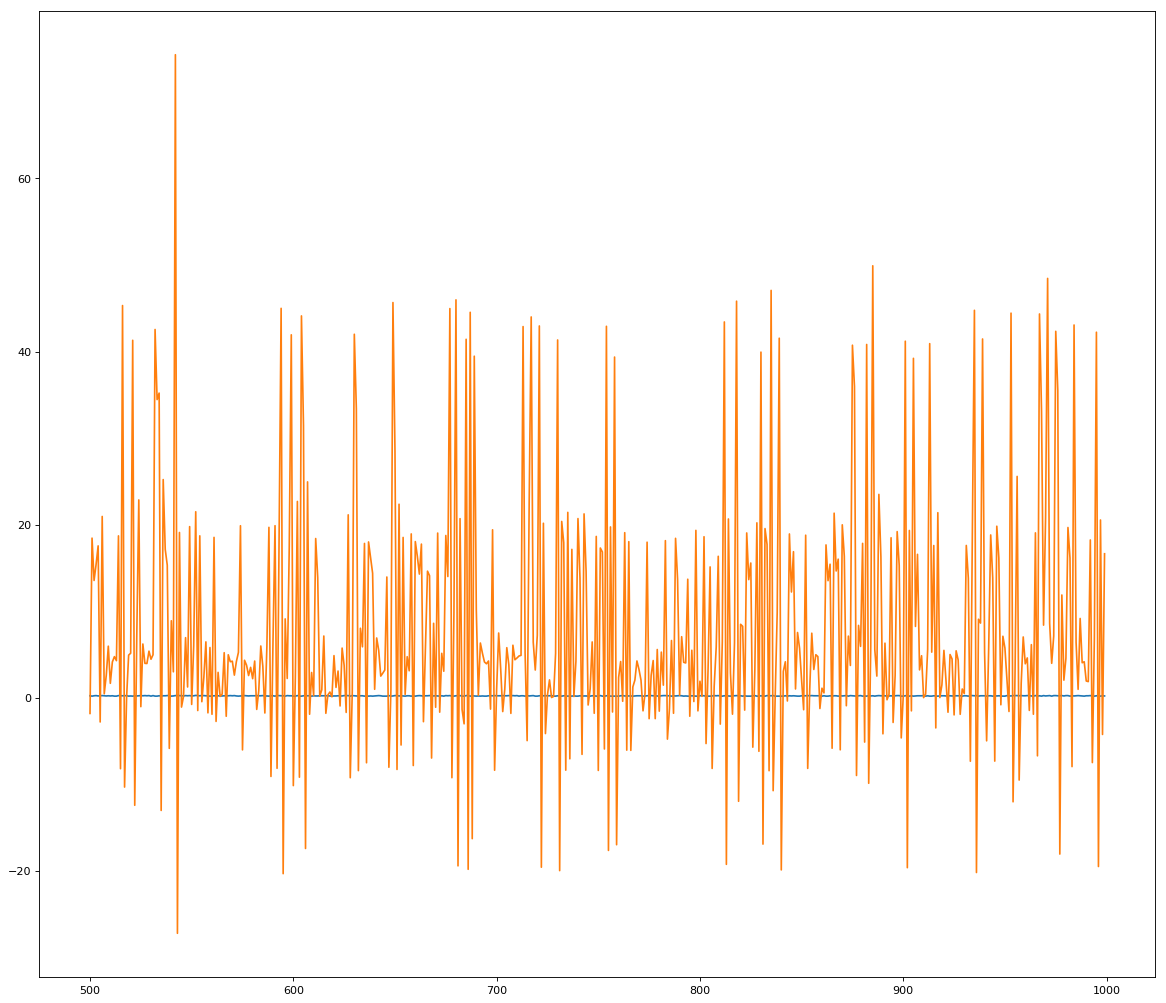

In [44]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
xstart, xend = 500,1000
#plt.plot(range(xstart, xend), scaler.transform(y_test[xstart:xend]).reshape(xend-xstart))
plt.plot(range(xstart, xend), scaler.transform(x_test[xstart:xend]).reshape(xend-xstart))
plt.plot(range(xstart, xend), out[xstart:xend].reshape(xend-xstart))
#plt.plot(range(xstart, xend), x_ema_array[xstart:xend].reshape(xend-xstart))

plt.show()

In [ ]:
from confluent_kafka import Consumer, KafkaError
import sys
import json
CONSUMER_CONFIG = {
    'bootstrap.servers': '127.0.0.1:9092',
    'enable.auto.commit': 'true',
    'group.id': 'labcamp',
    'default.topic.config': {
        'auto.offset.reset': 'earliest'
    }
}

topics = ["stream-data-cleaned"]

c = Consumer(CONSUMER_CONFIG)

c.subscribe(topics)

verbosity = False

try:
    input_list = [0.0,0.0]
    while True:
        msg = c.poll(timeout=1.0)
        #prendere solo il campo che serve
        #to float
        #in array e poi nella net
        if msg is None:
            continue
        if msg.error():
            continue
        else:
            # Proper message
            row = msg.value().decode('UTF-8').split(",")
            value = float(row[4])
            input_array = numpy.array([[[value]]])
            if verbosity: 
                print(input_array)
            out = model.predict(input_array)
            print("predicted: {0}".format(out))
            #c.commit()

except KeyboardInterrupt:
    sys.stderr.write('%% Aborted by user\n')

finally:
    # Close down consumer to commit final offsets.
    c.close()